<a href="https://colab.research.google.com/github/aditya2kahol/wandb-model-dev-course/blob/main/Course-Project/W%26B_Course_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W&B ML-Ops Model Development Course Project
## Project Topic: A self supervised learning technique for multi-focus image fusion.

<tt> Prepared by: Aditya Kahol </tt>

- What is image fusion? > [click here](https://en.wikipedia.org/wiki/Image_fusion)

- What is multi-focus image fusion? > [click here](https://en.wikipedia.org/wiki/Multi-focus_image_fusion)

This is the final report for the course project, but it does not mean that the work is complete, I will be continuing this work for my thesis.

In [ ]:
#import necessary libraries
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from pprint import pprint
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
#install wandb
!pip install wandb --upgrade --quiet

     |████████████████████████████████| 1.8 MB 37.9 MB/s 
     |████████████████████████████████| 181 kB 74.2 MB/s 
     |████████████████████████████████| 153 kB 74.8 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


In [ ]:
#import wandb
import wandb

In [ ]:
#set project name
PROJECT_NAME = "W&B Course-Project Image-Fusion"
ENTITY = None

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Now Download the dataset

In [ ]:
%%capture
!wget https://github.com/aditya2kahol/wandb-model-dev-course/raw/main/Course-Project/input.zip
!unzip /content/input.zip

In [ ]:
#set seeds for reproducibilty
def set_deterministic(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

    torch.set_default_dtype(torch.float32)

    return "Done"

SEED = 1234 # any number 
set_deterministic(seed = SEED)

'Done'

In [ ]:
filename = 'input'
#print number of training image pairs
print(len(os.listdir(filename)))

63


Creating pytorch dataset and dataloaders

In [ ]:
#parse image paths
def parse(index, filename):
    """
        PATHS: type -> List
    """
    i = 0 #starting index for search
    PATHS = [] #this list will contain the image names
    Found = False #flag used to terminate the code
    
    for file in os.listdir(filename):
        for image_name in os.listdir(filename + '/' + file):        
            if i == index:
                Found = True
                PATHS.append(filename + '/' + file + '/' + image_name)  
        if Found == True:
            break
        i += 1
        
    return PATHS

In [ ]:
#create a custom dataset which will output the image pairs for fusion
class custom_dataset(Dataset):
    def __init__(self, filename, transform = None):
        super().__init__()
        self.filename = filename
        self.length = len(os.listdir(filename))
        self.transform = transform
    
    def __len__(self):
        return self.length
    
    def __getitem__(self,idx):
        if idx >= self.length:
            print("You exceeded the count!")
            return None
        image_paths = parse(idx, self.filename)     
        Images = [] #List to contain images.
        for path in image_paths:
            if self.transform:
                Images.append(self.transform(Image.open(path)))
            else:
                Images.append(Image.open(path))
        return tuple(Images)

In [ ]:
#Define the transforms
transforms = T.Compose([T.Resize(size = (500,500)), T.ToTensor()])
"""
  even though resizing degrades the actual quality of the original image,
  we still have to do it, since cropping the images are sometimes hiding away
  some of the important features of the source images that we wish to capture
"""

'\n  even though resizing degrades the actual quality of the original image,\n  we still have to do it, since cropping the images are sometimes hiding away\n  some of the important features of the source images that we wish to capture\n'

In [ ]:
#create dataset
dataset = custom_dataset(filename, transform = transforms)
len(dataset)

63

In [ ]:
#define utility function to view images from the dataset
def view_image(ds):
    plt.figure(figsize = (18,10))
    plt.subplot(121)
    plt.imshow(ds[0].permute(1,2,0))
    plt.title("Image 1")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ds[1].permute(1,2,0))
    plt.title("Image 2")
    plt.axis("off")
    plt.show()
    return None

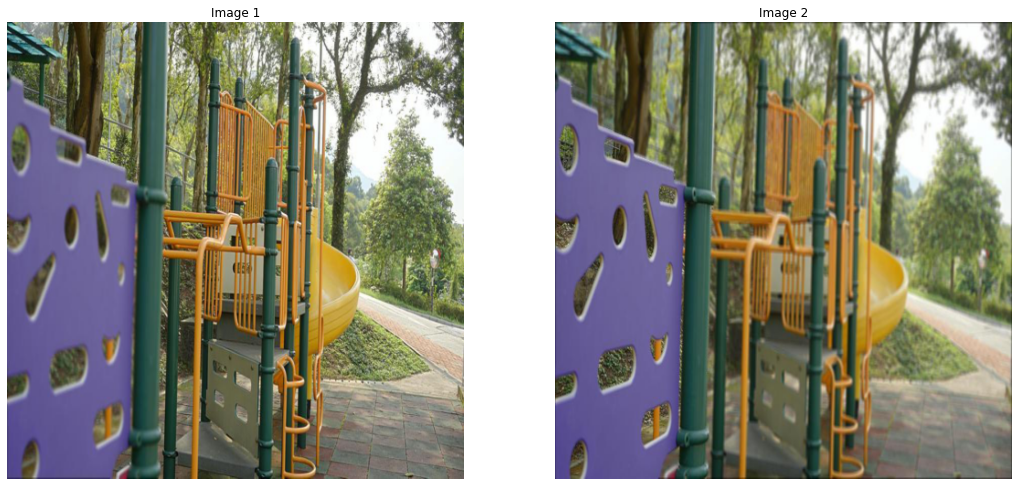

In [ ]:
view_image(dataset[15])

In [ ]:
# Create training and validation datasets
val_size = int(0.06 * len(dataset))
train_size = len(dataset) - val_size

#train-validation split
train_ds, val_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(60, 3)

In [ ]:
#Dataloaders
train_dl = DataLoader(dataset = train_ds,
                     batch_size = 20,
                     shuffle = False,
                     num_workers = 2,
                     pin_memory = True)

val_dl = DataLoader(dataset = val_ds,
                   batch_size = len(val_ds),
                   shuffle = False,
                   num_workers = 2,
                   pin_memory = True)

"""
  Due to computational limitations, we wont be changing the batch-size, so the dataloader is kept fixed.
"""

'\n  Due to computational limitations, we wont be changing the batch-size, so the dataloader is kept fixed.\n'

In [ ]:
#import Fusion model, custom SSIM loss, and other utility functions.
from Loss import MS_SSIM
from FusionModel import Fusion

In [ ]:
#set hyperparameter dictionaries.

config1 = dict(
  epochs = 150,
  optimizer = 'adam',
  learning_rate = 0.0009,
  batch_size = 20,
  dropout = 0.1,
  grad_clip = 0.9,
  weight_decay = 1e-5,
  momentum = None
)

config2 = dict(
    epochs = 150,
    optimizer = 'sgd',
    learning_rate = 0.0009,
    batch_size = 20,
    dropout = 0.2,
    grad_clip = 0.8,
    weight_decay = 1e-6,
    momentum = 0.95
)

config3 = dict(
    epochs = 100,
    optimizer = 'adam',
    learning_rate = 0.0001,
    batch_size = 20,
    dropout = 0.25,
    grad_clip = 0.75,
    weight_decay = 1e-4,
    momentum = None
)

config4 = dict(
    epochs = 200,
    optimizer = 'sgd',
    learning_rate = 0.0001,
    batch_size = 20,
    dropout = 0.25,
    grad_clip = 0.9,
    weight_decay = 1e-5,
    momentum = 0.9
)

In [ ]:
def fit(config_dict):
  history = dict(
      train_loss = [],
      val_loss = [])

  with wandb.init(project = PROJECT_NAME, entity = ENTITY, config = config_dict):
    config = wandb.config
    device = set_device()
    model = build_model(device, config.dropout)
    opt = build_optimizer(model, config.optimizer, config.learning_rate, config.weight_decay, config.momentum)
    criterion = MS_SSIM()
    wandb.watch(model)
    torch.cuda.empty_cache()
    for epoch in range(config.epochs):
      model.train()
      train_loss = 0
      val_loss = 0
      for batch in train_dl:
        train_loss += train_batch(model, batch, criterion, opt, device, config.grad_clip)
      model.eval()
      for batch in val_dl:
        val_loss += eval_batch(model, batch, criterion, device)
      if epoch%10 == 0:
        print(f"Epoch {epoch}/{config.epochs} Train-Loss: {train_loss/len(train_dl):.4f} Val-loss: {val_loss/len(val_dl):.4f}")
      history['train_loss'].append(train_loss/len(train_dl))
      history['val_loss'].append(val_loss/len(val_dl))
      wandb.log({"Train-Loss": train_loss/len(train_dl),
                "Val-Loss": val_loss/len(val_dl)})
  return model, history

In [ ]:
def set_device():
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  print("Available device: ",device)
  return device

In [ ]:
def build_model(device, dropout):
  model = Fusion(dropout).to(device)
  return model

In [ ]:
def build_optimizer(model, opt, lr, weight_decay, momentum):
  if opt == 'adam':
    optimizer = optim.Adam(model.parameters(),
                           lr = lr,
                           weight_decay = weight_decay)
  elif opt == 'sgd':
    optimizer = optim.SGD(model.parameters(),
                          lr = lr,
                          momentum = momentum,
                          weight_decay = weight_decay)
  return optimizer

In [ ]:
def train_batch(model, batch, criterion, optimizer, device, grad_clip):
  train_loss = 0
  img1, img2 = batch
  img1 = img1.to(device)
  img2 = img2.to(device)
  #forward pass
  fused = model(img1, img2)
  #loss calc
  loss = ( 1/criterion(fused,img1) + 1/criterion(fused,img2) )/2
  train_loss += loss.item()
  del fused, img1, img2
  #backward pass
  loss.backward()
  #gradient clipping
  if grad_clip:
    nn.utils.clip_grad_value_(model.parameters(), grad_clip)
  #update weights and set optimizer grad to zero
  optimizer.step()
  optimizer.zero_grad()

  return train_loss

In [ ]:
def eval_batch(model, batch, criterion, device):
  val_loss = 0
  with torch.no_grad():
    img1, img2 = batch
    img1 = img1.to(device)
    img2 = img2.to(device)
    fused = model(img1, img2)
    loss = ( 1/criterion(fused, img1) + 1/criterion(fused, img2) )/2
    val_loss += loss.item()
  return val_loss

In [ ]:
model1, history1 = fit(config1)

wandb: Currently logged in as: adi001. Use `wandb login --relogin` to force relogin


Available device:  cuda
Epoch 0/150 Train-Loss: 3.3556 Val-loss: 2.3411
Epoch 10/150 Train-Loss: 1.2115 Val-loss: 1.1893
Epoch 20/150 Train-Loss: 1.1479 Val-loss: 1.1259
Epoch 30/150 Train-Loss: 1.1204 Val-loss: 1.1019
Epoch 40/150 Train-Loss: 1.1021 Val-loss: 1.0850
Epoch 50/150 Train-Loss: 1.0901 Val-loss: 1.0757
Epoch 60/150 Train-Loss: 1.0894 Val-loss: 1.0731
Epoch 70/150 Train-Loss: 1.0819 Val-loss: 1.0645
Epoch 80/150 Train-Loss: 1.0858 Val-loss: 1.0703
Epoch 90/150 Train-Loss: 1.0918 Val-loss: 1.0947
Epoch 100/150 Train-Loss: 1.0784 Val-loss: 1.0678
Epoch 110/150 Train-Loss: 1.0768 Val-loss: 1.0620
Epoch 120/150 Train-Loss: 1.0729 Val-loss: 1.0699
Epoch 130/150 Train-Loss: 1.0690 Val-loss: 1.0589
Epoch 140/150 Train-Loss: 1.0744 Val-loss: 1.0684


Train-Loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val-Loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train-Loss,1.0742
Val-Loss,1.06634


In [ ]:
model2, history2 = fit(config2)

Available device:  cuda
Epoch 0/150 Train-Loss: 5.1670 Val-loss: 2.1290
Epoch 10/150 Train-Loss: 1.3803 Val-loss: 1.3670
Epoch 20/150 Train-Loss: 1.2453 Val-loss: 1.2118
Epoch 30/150 Train-Loss: 1.2206 Val-loss: 1.1839
Epoch 40/150 Train-Loss: 1.2113 Val-loss: 1.1781
Epoch 50/150 Train-Loss: 1.2065 Val-loss: 1.1748
Epoch 60/150 Train-Loss: 1.2035 Val-loss: 1.1729
Epoch 70/150 Train-Loss: 1.2013 Val-loss: 1.1711
Epoch 80/150 Train-Loss: 1.1994 Val-loss: 1.1698
Epoch 90/150 Train-Loss: 1.1978 Val-loss: 1.1687
Epoch 100/150 Train-Loss: 1.1963 Val-loss: 1.1678
Epoch 110/150 Train-Loss: 1.1948 Val-loss: 1.1668
Epoch 120/150 Train-Loss: 1.1933 Val-loss: 1.1660
Epoch 130/150 Train-Loss: 1.1915 Val-loss: 1.1652
Epoch 140/150 Train-Loss: 1.1880 Val-loss: 1.1636


Train-Loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val-Loss,███▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train-Loss,1.17679
Val-Loss,1.1539


In [ ]:
model3, history3 = fit(config3)

Available device:  cuda
Epoch 0/100 Train-Loss: 4.5057 Val-loss: 3.1752
Epoch 10/100 Train-Loss: 1.6757 Val-loss: 1.6441
Epoch 20/100 Train-Loss: 1.4543 Val-loss: 1.4327
Epoch 30/100 Train-Loss: 1.3623 Val-loss: 1.3526
Epoch 40/100 Train-Loss: 1.3112 Val-loss: 1.2988
Epoch 50/100 Train-Loss: 1.2768 Val-loss: 1.2594
Epoch 60/100 Train-Loss: 1.2506 Val-loss: 1.2304
Epoch 70/100 Train-Loss: 1.2299 Val-loss: 1.2093
Epoch 80/100 Train-Loss: 1.2133 Val-loss: 1.1925
Epoch 90/100 Train-Loss: 1.1997 Val-loss: 1.1794


Train-Loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val-Loss,█▅▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train-Loss,1.18956
Val-Loss,1.17084


In [ ]:
model4, history4 = fit(config4)

Available device:  cuda
Epoch 0/200 Train-Loss: 5.1315 Val-loss: 3.1876
Epoch 10/200 Train-Loss: 1.6195 Val-loss: 1.5675
Epoch 20/200 Train-Loss: 1.4833 Val-loss: 1.4428
Epoch 30/200 Train-Loss: 1.4305 Val-loss: 1.3867
Epoch 40/200 Train-Loss: 1.3968 Val-loss: 1.3529
Epoch 50/200 Train-Loss: 1.3717 Val-loss: 1.3278
Epoch 60/200 Train-Loss: 1.3522 Val-loss: 1.3081
Epoch 70/200 Train-Loss: 1.3362 Val-loss: 1.2925
Epoch 80/200 Train-Loss: 1.3228 Val-loss: 1.2796
Epoch 90/200 Train-Loss: 1.3115 Val-loss: 1.2688
Epoch 100/200 Train-Loss: 1.3018 Val-loss: 1.2598
Epoch 110/200 Train-Loss: 1.2935 Val-loss: 1.2521
Epoch 120/200 Train-Loss: 1.2864 Val-loss: 1.2457
Epoch 130/200 Train-Loss: 1.2802 Val-loss: 1.2401
Epoch 140/200 Train-Loss: 1.2748 Val-loss: 1.2352
Epoch 150/200 Train-Loss: 1.2700 Val-loss: 1.2308
Epoch 160/200 Train-Loss: 1.2658 Val-loss: 1.2269
Epoch 170/200 Train-Loss: 1.2620 Val-loss: 1.2234
Epoch 180/200 Train-Loss: 1.2585 Val-loss: 1.2204
Epoch 190/200 Train-Loss: 1.2554 Val-

Train-Loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val-Loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train-Loss,1.25281
Val-Loss,1.21524


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def display_result(val_ds, model, device):
  img1, img2 = val_ds
  torch.cuda.empty_cache()
  I1 = img1.unsqueeze(0).to(device)
  I2 = img2.unsqueeze(0).to(device)
  model.eval()
  fused = model(I1, I2)
  fused = fused.squeeze(0).detach().cpu().permute(1,2,0)
  plt.figure(figsize = (19,12))
  plt.subplot(131)
  plt.imshow(img1.permute(1,2,0))
  plt.title("Image1")
  plt.axis("off")
  plt.subplot(132)
  plt.imshow(img2.permute(1,2,0))
  plt.title("Image2")
  plt.axis("off")
  plt.subplot(133)
  plt.imshow(fused)
  plt.title("Fused image")
  plt.axis("off")
  plt.show()
  del I1, I2, fused
  return None

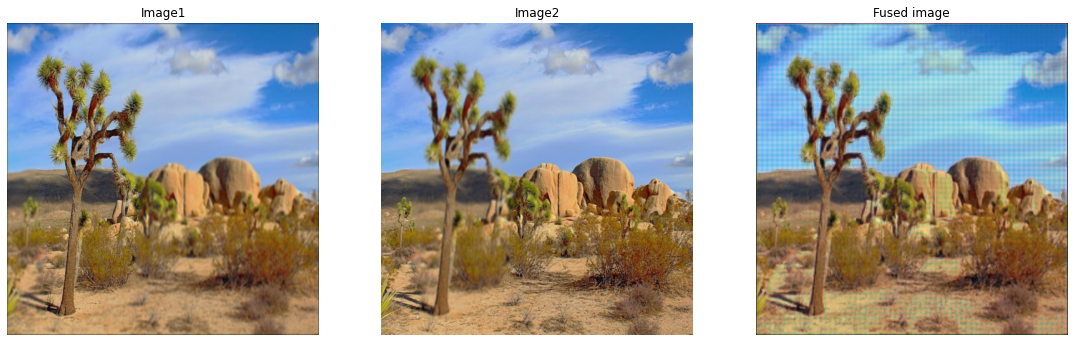

In [ ]:
display_result(dataset[0], model1, device)

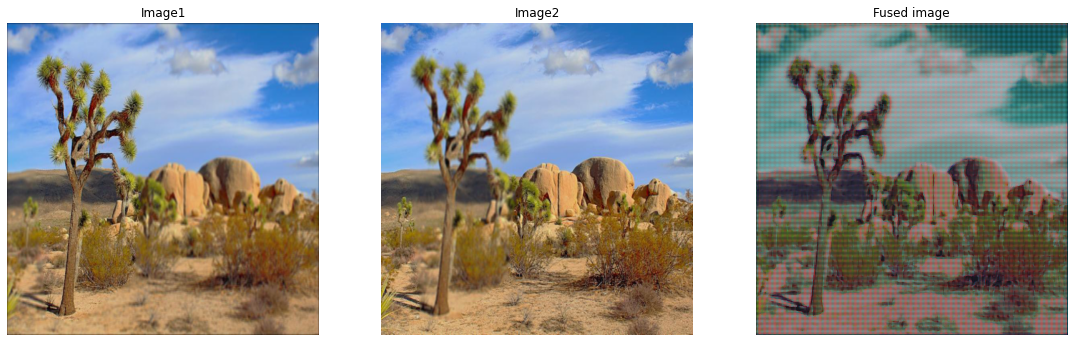

In [ ]:
display_result(dataset[0], model2, device)

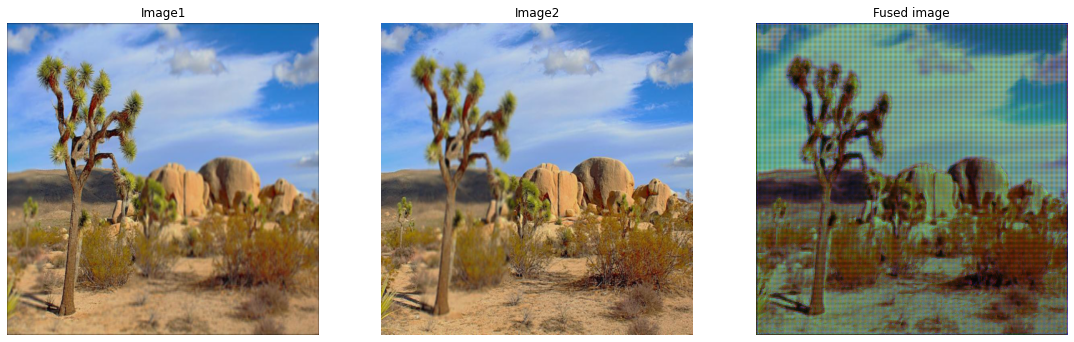

In [ ]:
display_result(dataset[0], model3, device)

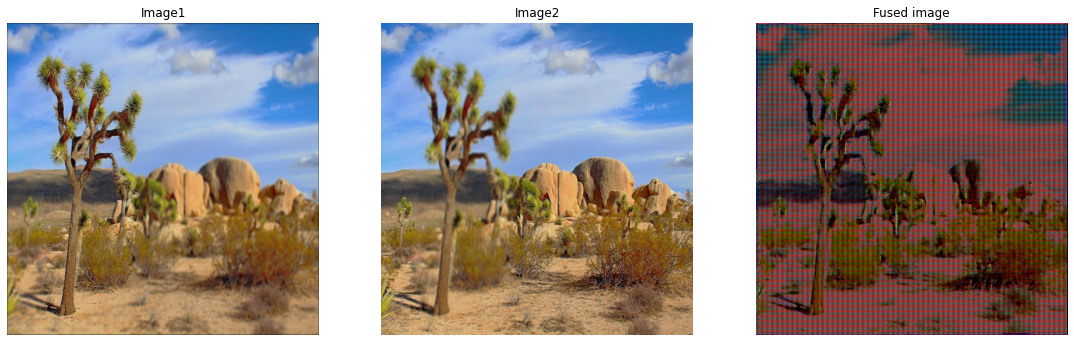

In [ ]:
display_result(dataset[0], model4, device)

In [ ]:
def make_rows(model, ds):
  img1, img2 = ds
  I1 = img1.unsqueeze(0).to(device)
  I2 = img2.unsqueeze(0).to(device)

  fused = model(I1, I2)
  fused = fused.squeeze(0).detach().cpu()

  return [wandb.Image(img1.permute(1,2,0).numpy()), 
          wandb.Image(img2.permute(1,2,0).numpy()),
          wandb.Image(255*fused.permute(1,2,0).numpy())]

#check function output
make_rows(model1, val_ds[0])

In [ ]:
#Log the validation set images in a table
df = pd.DataFrame(columns = ["Source-image1","Source-image2","Fused-image"])
with wandb.init(project=PROJECT_NAME, entity=ENTITY, job_type="Fused-images") as run:
  #for model in [model1, model2, model3, model4]:
  for i in range(len(dataset)):
    img1, img2, fused = make_rows(model1, dataset[i])
    df = df.append({"Source-image1":img1, "Source-image2": img2, "Fused-image": fused}, 
                ignore_index = True)
  run.log({'Best-Model-Fused-Images': wandb.Table(dataframe=df)})

In [ ]:
architecture = Image.open('Baseline-model.png')

In [ ]:
with wandb.init(project=PROJECT_NAME, entity=ENTITY, job_type="Model architecture") as run:
  run.log({"Model architecture":wandb.Image(architecture)})

In [ ]:
#save the best model's state dict
"""
torch.save(model1.state_dict(), 'model1_weights.pth')

#torch.save(model2.state_dict(), 'model2_weights.pth')
#torch.save(model3.state_dict(), 'model3_weights.pth')
#torch.save(model4.state_dict(), 'model4_weights.pth')
"""

"\ntorch.save(model1.state_dict(), 'model1_weights.pth')\ntorch.save(model2.state_dict(), 'model2_weights.pth')\ntorch.save(model3.state_dict(), 'model3_weights.pth')\ntorch.save(model4.state_dict(), 'model4_weights.pth')\n"